#Face Recognition (Siamese Network - Contrastive loss)


## important Libraries

In [ ]:
from data_utils import create_validation_data

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

use_gpu = torch.cuda.is_available()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper Methods

In [10]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, mean, std, text=None, should_save=False):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)

    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

Data - Subset of ORL Data set (10: person with 10 color photos)

**Data** - Subset of **ORL** Data set (10 person with 10 color photos)

**setup Training Dataset:**
we have 10 folders, each representing a different person.
Inside each person's folder, we have 10 photos of that person.
The folder names are the names of the persons.
The photo filenames follow the format "PersonName-00##."


**setup Validation  Dataset:**

if your goal is to evaluate the model's to **recognize unseen individuals** or **generalization to new individuals** : you might consider having a more diverse set of individuals in the validation dataset. In that case, you could create a validation dataset with 10 folders, each containing 2 photos, but from different individuals not present in the training set.


if your goal is "**verification task** " and the goal is to evaluate the model's performance on recognizing individuals based on the 2 provided photos for each person then You have to make 10 folders for the validation set, Inside each person's folder, you have ***2 photos of that person***.


 10 validation folders (Validation_01 to Validation_10), each containing 2 photos (Photo_01 and Photo_02). These photos are from individuals not present and also peresent in the training dataset.




In [11]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:

train_dir = '/content/drive/My Drive/face recognition/Train Siamese/'

In [13]:

valid_dir = '/content/drive/My Drive/face recognition/validation Siamese/'

In [14]:
# Constants
sz = 96
batch_size = 8
embed_size = 128
num_epochs = 200
cnn_name = 'resnet50'

#Statistics
- Average width = 250.00

- Average height = 250.00

- Mean: [0.000, 0.000, 0.000]

- Std: [0.000, 0.000, 0.000]

In [15]:
images = [f for f in glob(f'{train_dir}/*/*.jpg')]   # training images
images += [f for f in glob(f'{valid_dir}/*/*.jpg')]  # validation images

num_images = len(images)
avg_width, avg_height = 0.0, 0.0
for img_fname in tqdm(images, desc='Gathering statistics'):
    w, h = Image.open(img_fname).size
    avg_width += w
    avg_height += h

avg_width /= num_images
avg_height /= num_images

print('Average width: {:.2f}, Average height: {:.2f}'.format(avg_width, avg_height))

# how about mean and std

Gathering statistics: 100%|██████████| 134/134 [01:58<00:00,  1.13it/s]

Average width: 250.00, Average height: 250.00


**Dataset**

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:
Create a subclass of torch.utils.data.Dataset


Override the following three methods:

The constructor or __init__(): this method is required to initialize the dataset object.

The __getitem__() method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.

The __len__() method: this method returns number of data in the dataset.

In [18]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imgs, transform=None):
        """ Constructor
        Inputs:
            imgs: a list of images and their corresponding labels
            transform: required transformations
        """
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()

    def __getitem__(self, index):
        # select the image with given index from dataset
        anchor, anchor_label = self.imgs[index]

        # we need to make sure approx 50% of images are in the same class
        is_negative = random.random() < 0.5
        if is_negative:
            second = random.choice([img for img, label in self.imgs if label != anchor_label])
        else:
            second = random.choice([img for img, label in self.imgs if label == anchor_label])

        # read pair of images
        anchor_img = Image.open(anchor).convert('RGB')
        second_img = Image.open(second).convert('RGB')

        # perform given transformations (if any)
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            second_img = self.transform(second_img)

        return anchor_img, second_img, torch.Tensor([int(is_negative)])

    def __len__(self):
        return len(self.imgs)


**Training data**

In [19]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

In [20]:
#zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom
stats = ([0.50480222, 0.4073655, 0.37700788], [0.29478898, 0.25199998, 0.2384155])

"""The stats variable in the code represents the mean and standard deviation values for each channel (Red, Green, Blue)
of the images in a dataset. These values are used for normalization during data preprocessing."""

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomGrayscale(0.2),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])


valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [21]:
# training data
face_dataset = datasets.ImageFolder(train_dir)
train_ds = SiameseNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

In [22]:
# validation data
valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = SiameseNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

#Visualize dataset

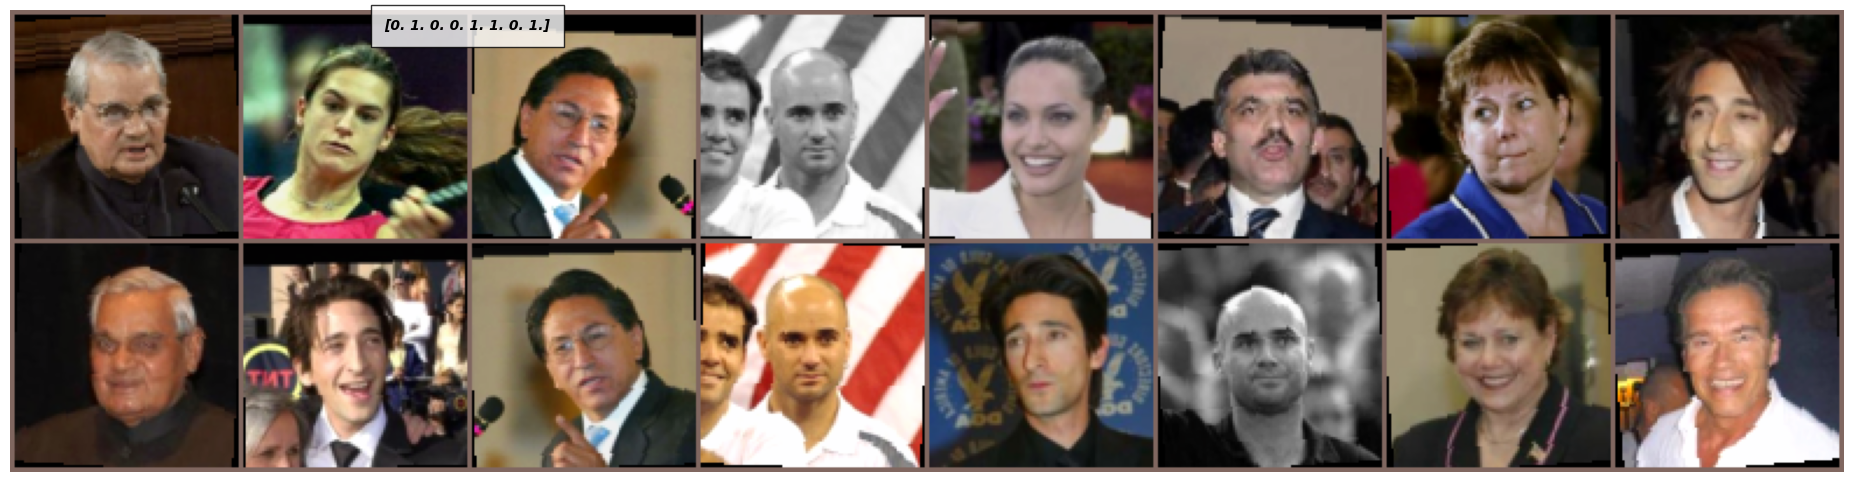

In [23]:
anchor_imgs, second_imgs, labels = next(iter(train_dl))
concat = torch.cat((anchor_imgs, second_imgs), 0)
labels = labels.numpy().T
plt.figure(figsize=(24, 6))
imshow(torchvision.utils.make_grid(concat, nrow=8),
       mean=stats[0], std=stats[1], text=f'{labels[0]}')

#Model: **Siamese Netwok**

In [24]:
class SiameseNetwork(nn.Module):

    def __init__(self, cnn, embed_size=128):
        super(SiameseNetwork, self).__init__()

        num_features = cnn.fc.in_features
        cnn.fc = nn.Linear(num_features, embed_size)
        self.cnn = cnn

    def forward(self, x1, x2):
        f1 = self.cnn(x1)
        f2 = self.cnn(x2)
        return f1, f2

#Loss: Contrastive Loss

Contrastive Loss is a loss function used for learning similarity-preserving embeddings in a way that encourages similar samples to be close and dissimilar samples to be separated in the embedding space. It achieves this by penalizing embeddings that violate the desired margin condition for dissimilar pairs.

Loss = 0.5 * (1 - Y) * D^2 + 0.5 * Y * max(0, m - D)^2

Y is a binary variable that represents whether the pair of samples (e.g., images) are similar (Y = 1) or dissimilar (Y = 0).

- D is the Euclidean distance (L2 distance) between the embeddings of the two samples. It quantifies the dissimilarity between the samples in the embedding space.

- m is a hyperparameter known as the margin. It defines a threshold distance, and if D exceeds this margin for dissimilar pairs, it contributes to the loss.

**Explanation:**

For similar pairs (where Y = 1), the loss encourages the model to minimize the distance D between the embeddings of the two samples. This brings similar samples closer together in the embedding space.

For dissimilar pairs (where Y = 0), the loss encourages the model to ensure that the distance D is greater than the margin m. If D is smaller than m, the loss will be positive, and the model will be penalized for bringing dissimilar samples too close in the embedding space.

The goal of Contrastive Loss is to find an embedding space where similar samples have small distances and dissimilar samples have distances greater than the margin. This learned embedding space can then be used for tasks such as image similarity retrieval, face verification, or other tasks where measuring similarity between data points is important.

- similarity between data points is often reflected in their proximity or distance from each other. Similar data points are closer together, while dissimilar data points are farther apart.

- Embedding spaces typically have lower dimensionality compared to the original data space.Embedding spaces are often visualized in two or three dimensions for human interpretation, even though the actual space may have many more dimensions. Dimensionality reduction techniques like t-SNE or PCA are commonly used for this purpose.

- embedding spaces are learned from data using neural networks. For example, in image recognition, a convolutional neural network (CNN) can learn to map images into an embedding space where images of the same class cluster together.

- Embedding spaces find applications in various machine learning tasks, such as image similarity retrieval, text analysis, recommendation systems, and natural language processing (NLP). For instance, word embeddings in NLP (e.g., Word2Vec or GloVe) map words into a continuous vector space where semantically similar words are close together.





In [25]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# **Train**

In [26]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()

    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(train_dl):
        imgs0, imgs1, lbls = imgs0.to(device), imgs1.to(device), lbls.to(device)

        # forward
        features0, features1 = model(imgs0, imgs1)

        # loss
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return model, avg_loss


def validate_step(model, valid_dl, criterion, device):
    model.eval()

    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0

    with torch.no_grad():
        for i, (imgs0, imgs1, lbls) in enumerate(valid_dl):
            imgs0, imgs1, lbls = imgs0.to(device), imgs1.to(device), lbls.to(device)

            features0, features1 = model(imgs0, imgs1)
            loss = criterion(features0, features1, lbls)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return avg_loss



def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()

    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch + 1}\n--------')

        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
            torch.save(best_weights, f'tmp/{cnn_name}-facereco-iranians-{epoch}-{best_loss}.pth')
        print()

    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, loss_history

In [33]:
import os

# Directory path for saving/loading checkpoints
checkpoint_dir = 'tmp'  # You can change this path to match your specific directory structure

# Check if the directory exists
if not os.path.exists(checkpoint_dir):
    # If it doesn't exist, create the directory
    os.makedirs(checkpoint_dir)
    print(f"Created '{checkpoint_dir}' directory.")
else:
    print(f"'{checkpoint_dir}' directory already exists.")

# training and validation data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model
#cnn = get_model(cnn_name)
cnn = get_model(cnn_name, pretrained=True)

model = SiameseNetwork(cnn, embed_size)
model = model.to(device)

# loss and optimizer
criterion = ContrastiveLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

model

model, loss_hist = train(model,
                         train_dl,
                         valid_dl,
                         criterion,
                         optimizer,
                         device,
                         scheduler,
                         num_epochs=50)



Created 'tmp' directory.
Epoch 1
--------
 Training Step [13/13]: loss 7.84930  
 Validation Step [5/5]: loss 2.17371  

Epoch 2
--------
 Training Step [13/13]: loss 2.53512  
 Validation Step [5/5]: loss 1.63534  

Epoch 3
--------
 Training Step [13/13]: loss 1.35053  
 Validation Step [5/5]: loss 1.27437  

Epoch 4
--------
 Training Step [13/13]: loss 1.02910  
 Validation Step [5/5]: loss 1.10098  

Epoch 5
--------
 Training Step [13/13]: loss 1.04814  
 Validation Step [5/5]: loss 1.12789  

Epoch 6
--------
 Training Step [13/13]: loss 1.03763  
 Validation Step [5/5]: loss 1.22272  

Epoch 7
--------
 Training Step [13/13]: loss 1.01126  
 Validation Step [5/5]: loss 1.11803  

Epoch 8
--------
 Training Step [13/13]: loss 0.99555  
 Validation Step [5/5]: loss 1.03027  

Epoch 9
--------
 Training Step [13/13]: loss 1.01860  
 Validation Step [5/5]: loss 1.16013  

Epoch 10
--------
 Training Step [13/13]: loss 1.02960  
 Validation Step [5/5]: loss 1.03284  

Epoch 11
-----

In [30]:
model

SiameseNetwork(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

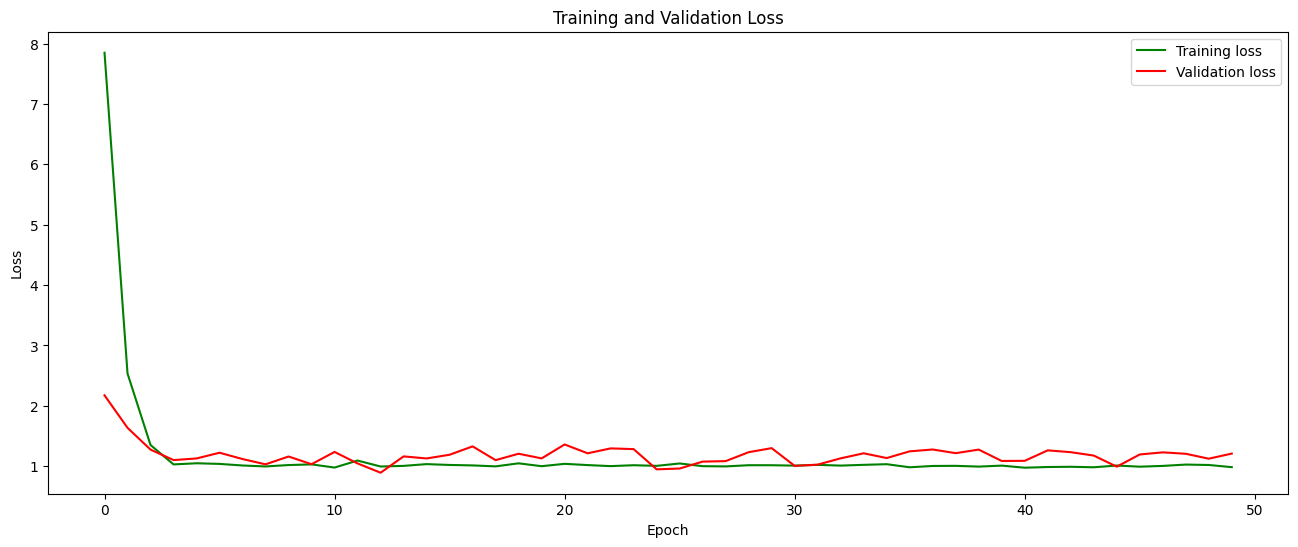

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# **Testing**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#TEST_DIR = '/content/drive/My Drive/face recognition/test images/'

In [35]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

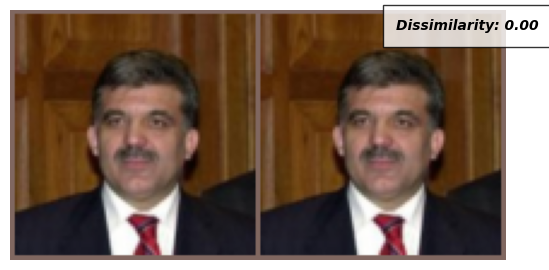

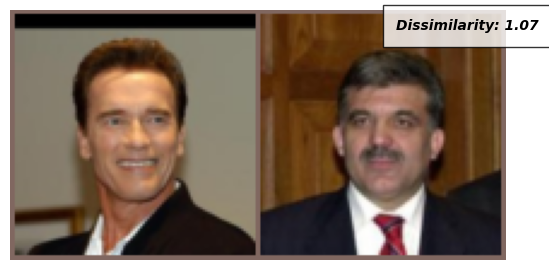

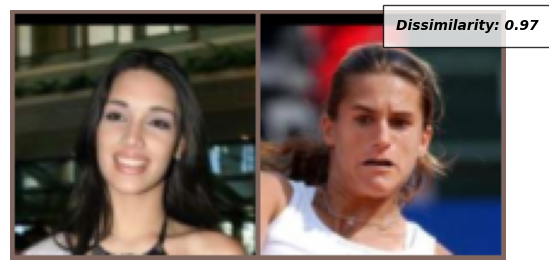

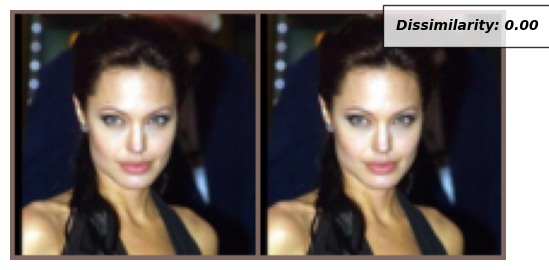

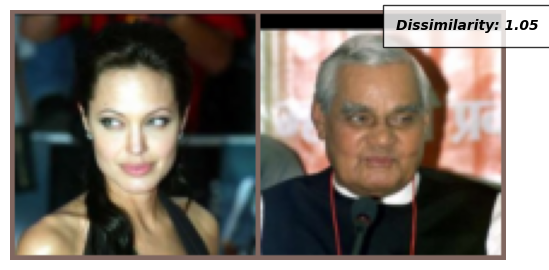

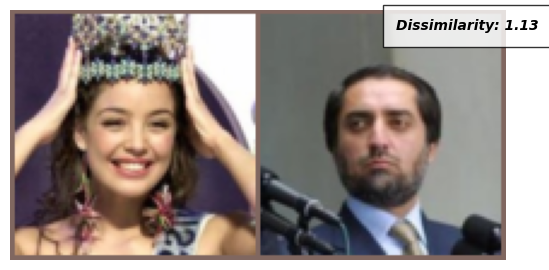

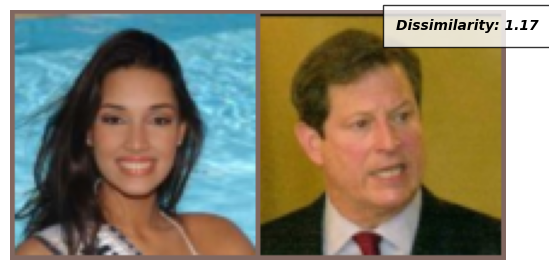

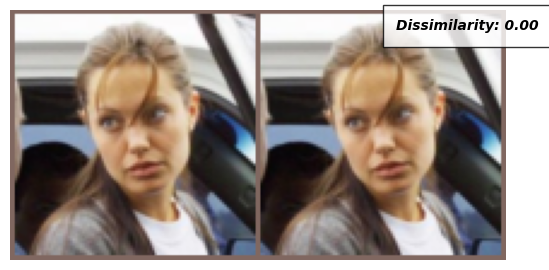

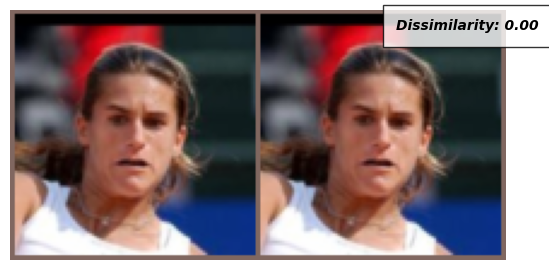

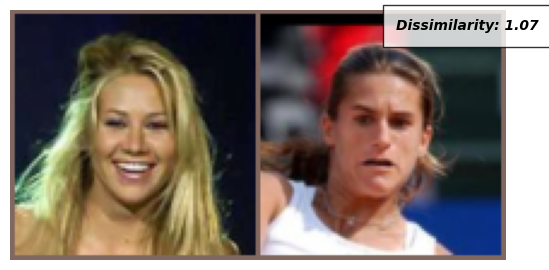

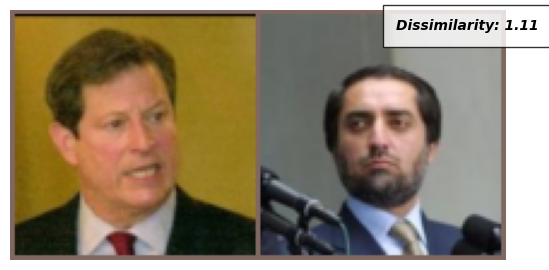

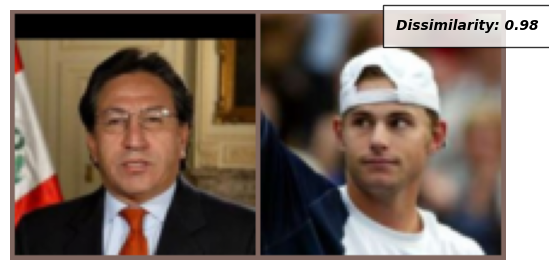

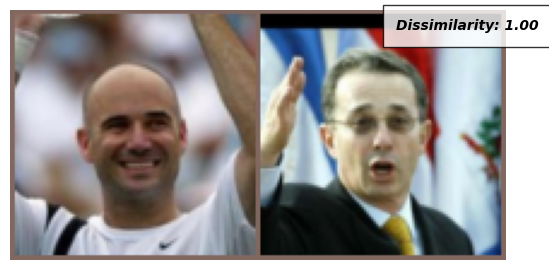

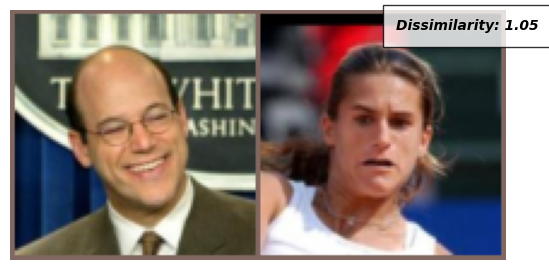

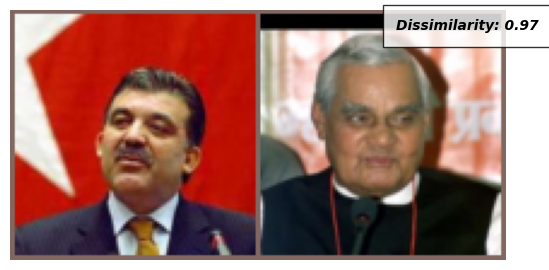

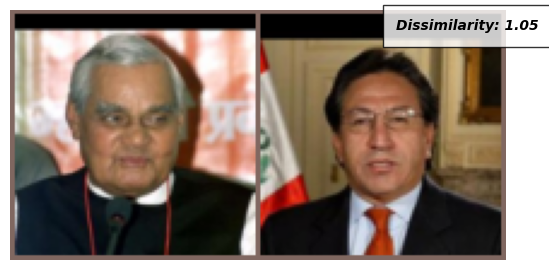

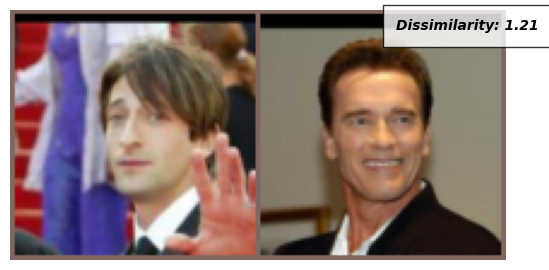

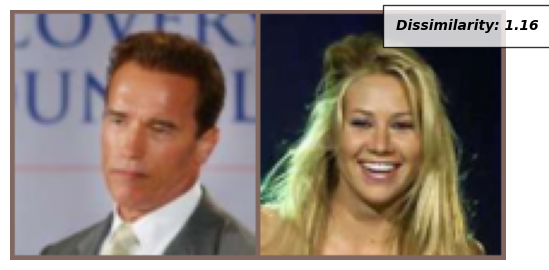

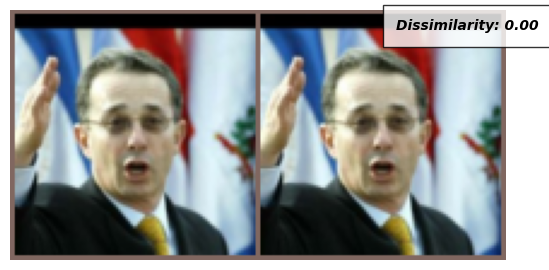

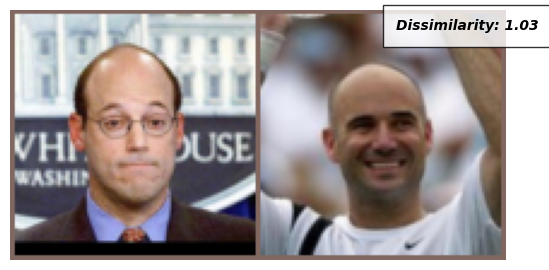

In [36]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, _ = next(dataiter)
        concat = torch.cat((x0, x1), 0)
        x0, x1 = x0.to(device), x1.to(device)
        f0, f1 = model(x0, x1)
        euclidean_distance = F.pairwise_distance(f0, f1)
        imshow(torchvision.utils.make_grid(concat),
               mean=stats[0], std=stats[1],
               text=f'Dissimilarity: {euclidean_distance.item():.2f}')